# Variational autoencoders for missing data completion and denoising of neuroimaging data

Variational autoencoders have been demonstrated to be powerful generative models for learning a lower-dimensional latent distribution of high dimensional data and then generate data from that distribution. This has numerous applications such as denoising documents or audio, or even generating faces and music. Its application in neuroimaging have been limited, however, due to lack of large datasets. Neuroimaging data is 3D, adding another layer of complexity.

Neuroimaging data is mired with signal artifacts induced by motion, inhomogeneties in the magnetic field, even field-of-view issues causing cropping and loss of data. In diffusion imaging, signal dropout is very common and is usually an important quality control metric that can determine whether a subject is included or not. In fact, distortion removal pipelines typically require a separate scan in the opposite phase encoding direction, which is usually not acquired due to time or funding constraints. Thus, many diffusion images contain significant distortions in brain voxels, especially near the cerebellum and frontal cortex. The presence of numerous artifacts, on top of the difficulty in acquiring subjects for a neuroimaging study, make it very challenging to compile a large clean neuroimaging dataset and test generalizable hypotheses about the brain's structure and function.

Here, we will attempt to recover lost signal due to field-of-view/cropping issues in DTI data using variational autoencoders. We will try to extend this to clean other artifacts in DTI data, such as signal dropout and distortions. We've demonstrated in a previous notebook that we can denoise 2D image data with VAEs. We simply need to extend this to 3D images.

First, we must load a DWI file from a subject. Each file has several volumes corresponding with a certain b-value. We will first train on b0 volumes. Let's see how we can load one...

## Load libraries and file paths

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.plotting import plot_anat
from nilearn.image import index_img

# load list of subject DWI files
dwi_files = np.loadtxt('dwi_file_list.txt', dtype=str)
# create list of subject bval files
bvals = [file[:-7] + '.bval' for file in dwi_files]

# Extract indices of image corresponding to b0 volumes
def getb0(bval_file):
    b = np.loadtxt(bval_file)
    # The b0 volumes in HCP data actually have a value of 5, so check both 0 and 5
    b_ind = np.concatenate((np.where(b == 5)[0], np.where(b == 0)[0]))
    return b_ind

# Dictionary that maps file name to indices of where the b0 volumes are within each file
dwi2b0 = {dwi_files[ind] : getb0(file) for ind,file in enumerate(bvals)}

## Visualize a random sample image

In [ ]:
# Takes an image file and the map from filename to indices of b0 volumes to load the right image data
def loadb0(img_file, file2b_ind, as_type = 'nib', normalize = True):
    # as_type should either be nib for nibabel format or np for numpy array
    if as_type not in ['nib', 'np']:
        raise TypeError('Incorrect option for as_type. Use either nib or np.')
    # Load image
    img = nib.load(img_file)
    # Remove non b0 volumes
    img_fixed = img.get_fdata()[:,:,:,file2b_ind[img_file]]
    # Normalize intensity to range of 0 to 1
    if normalize:
        img_fixed = (img_fixed - np.min(img_fixed, axis = (0,1,2))) / (np.max(img_fixed, axis = (0,1,2)) - np.min(img_fixed, axis = (0,1,2)))
    if as_type == 'np':
        return img_fixed
    elif as_type == 'nib':
        # Reform as image data type
        img_fixed = nib.Nifti1Image(img_fixed, np.eye(4))
        return img_fixed

In [ ]:
# Random file
idx = np.random.choice(dwi_files.shape[0], 1)[0]
dwi = loadb0(dwi_files[0], dwi2b0)
dwi = dwi.get_fdata()
dwi[:,:,-15:,:] = dwi[:,:,-15:,:] + np.random.normal(0.1, 0.01, size = dwi[:,:,-15:,:].shape)
dwi = nib.Nifti1Image(dwi, np.eye(4))
num_vol = dwi.shape[-1]
plt.close('all')
fig,ax = plt.subplots(num_vol,1, figsize = (16,20))
for i in range(num_vol):
    # Plot all b0 volumes, intensity scaled such that we can see the skull clearly
    plot_anat(index_img(dwi, i), axes = ax[i], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
plt.show()

## Data augmentation

Let's see if we can simply reconstruct the 3D images with a VAE. We will need to perform data augmentation to expand our training set. We can do this by adding small rotations, translations, adding noise, or changing brightness and contrast. Let's create a function that can perform this and test it on a sample image.

In [ ]:
from scipy.ndimage import rotate, shift
from skimage.util import random_noise

def add_rotation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    axes = [0,1,2]
    axes.remove(axis)
    # Apply rotation
    img_rotated = rotate(img, amount, axes = tuple(axes), reshape = False)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_rotated = nib.Nifti1Image(img_rotated, np.eye(4))
    
    return img_rotated

def add_translation(image3d, amount, axis):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
        
    shift_apply = np.zeros((3,))
    shift_apply[axis] = amount
    # Apply translation
    img_translated = shift(img, shift_apply)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img_translated = nib.Nifti1Image(img_translated, np.eye(4))
        
    return img_translated

def add_noise(image3d, amount = 0.0001):
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        img = image3d.get_fdata()
    else:
        img = np.array(image3d)
    
    noisy_img = random_noise(img, mode = 'gaussian', clip = True, var = amount)
    
    if isinstance(image3d, nib.nifti1.Nifti1Image):
        noisy_img = nib.Nifti1Image(noisy_img, np.eye(4))
    
    return noisy_img

idx = np.random.choice(dwi_files.shape[0], 1)[0]
dwi = loadb0(dwi_files[0], dwi2b0)
print('Adding rotation')
dwi_rotated = add_rotation(index_img(dwi,0), 10, 0)
print('Adding translation')
dwi_translated = add_translation(index_img(dwi,0), 10, 0)
print('Adding noise')
dwi_noisy = add_noise(index_img(dwi,0))

plt.close('all')
fig,ax = plt.subplots(4,1, figsize = (16,14))
plot_anat(index_img(dwi, 0), axes = ax[0], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[0].set_title('original')
plot_anat(dwi_rotated, axes = ax[1], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[1].set_title('rotated 10 degrees')
plot_anat(dwi_translated, axes = ax[2], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[2].set_title('translated 10 voxels')
plot_anat(dwi_noisy, axes = ax[3], vmin = -0.1, vmax = 0.3, cut_coords = (80,70,60))
ax[3].set_title('noisy')
plt.show()

Now we are ready to put our loading and data augmentation functions to use. We could perform live data augmentation - that is, we modify data as we read them, not physically expanding the dataset. However, reading neuroimaging files and process them takes way too long and we don't want to burn training time continuously loading from the disk. Instead, we will perform all the augmentations and store the full dataset on disk. With augmentation, there should be about 8400 samples (6 possible rotations, 6 possible translations, 1 noise, meaning 600 + 14 = 8400 images) times 6 b0 volumes per image meaning about 50,400 training samples total. This will take about 1 TB of space... good thing we're on Sherlock and I have a quota of 100 TB!

In [ ]:
file_list = []
for ind,file_path in enumerate(dwi_files):
    #if ind < 130: continue
    #print('Augmenting ' + file_path)
    print('Processing %d of %d files' % ((ind + 1), dwi_files.shape[0]))
    subj = file_path.split('/')[1]
    dwi = loadb0(file_path, dwi2b0, as_type = 'np')
    # Use each b0 volume as an independent input
    for b0 in range(dwi.shape[-1]):
        #print('\tb0 volume %d out of %d' % ((b0+1),dwi.shape[-1]))
        # Original file
        prefix = 'traindata/' + subj + '/' + file_path.split('/')[-1][:-7] + '_b0vol' + str(b0+1)
        savename = prefix + '_original.npy'
        np.save(savename, dwi[:,:,:,b0])
        file_list.append(savename)
        # Rotate and translate
        i = 1
        for amount in [-10, 10]:
            for axis in [0,1,2]:
                dwi_preprocess = add_rotation(dwi[:,:,:,b0], amount, axis)
                savename = prefix + '_rotate' + str(i) + '.npy'
                np.save(savename, dwi_preprocess)
                file_list.append(savename)
                dwi_preprocess = add_translation(dwi[:,:,:,b0], amount, axis)
                savename = prefix + '_translate' + str(i) + '.npy'
                np.save(savename, dwi_preprocess)
                file_list.append(savename)
                i += 1
        # Noise
        dwi_preprocess = add_noise(dwi[:,:,:,b0])
        savename = prefix + '_noisy.npy'
        np.save(savename, dwi_preprocess)
        file_list.append(savename)
print('Number of training samples: ' + str(len(file_list)))

## Image reconstruction

Now we are ready to implement the VAE model in PyTorch to train on our augmented dataset. We will code the architecture of the model in separate Python files and import them here.

#### Load libraries and set parameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import numpy as np
import time, datetime
from Dataset import Dataset
from Models import VAE3D, UVAE3D, UNet, VQVAE3D
from utils import *
from loss import *
from config import *
import pickle, os

# ===============================================================
# SPECIFY THESE
# ===============================================================
num_train = 40000
batch_size = 128
crop = True
max_epochs = 40
cpu_batch_load_workers = 8
log_every_num_batches = 40
latent_dim = 512
model_save_path = 'models/vq_batchnorm/'
input_shape = (1,144,176,64)
num_filters = 16
embedding_dim = 32
num_embeddings = 512
loss_function = recon_masked_loss
pad = True
skip = True
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0
# encoder_config = encoder_deeper
# decoder_config = decoder_deeper
# ===============================================================
# end
# ===============================================================

#### Set up data generators and model object

In [2]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': cpu_batch_load_workers}

# Datasets
dwi_files_npy = np.loadtxt('X_files.txt', dtype=str)
num_val = dwi_files_npy.shape[0] - num_train

# Generators
training_set = Dataset(dwi_files_npy[:num_train], corrupt_prob = train_corrupt_prob, crop = crop, pad = pad)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, crop = crop, pad = pad)
validation_generator = data.DataLoader(validation_set, **params)


#model = VAE3D(input_shape, latent_dim, num_filters, encoder_config, decoder_config)
#model = UVAE3D(input_shape, latent_dim, num_filters)
model = VQVAE3D(input_shape[0], num_filters, embedding_dim = embedding_dim, num_embeddings = num_embeddings, skip_connections = skip)
#model = UNet(input_shape[0], num_filters)
# with open('models/unet/history.p', 'rb') as f:
#     history = pickle.load(f)

# model = torch.load('models/unet/Epoch_17_Train_loss_19607.8943_Test_loss_23216.2543.pth')

print(model)

# Optimization function
optimizer = optim.Adam(model.parameters(), lr=1e-3)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, k

#### Train model and save weights

In [ ]:
history = {'train': [], 'test': []}

# Loop over epochs
for epoch in range(max_epochs):
#for epoch in range(17, 40, 1):
    t0 = time.time()
    # Training
    train_loss = train(model, optimizer, loss_function, training_generator, epoch, log_every_num_batches = log_every_num_batches)

    # Validation
    test_loss = test(model, loss_function, validation_generator)
    
    savepath = os.path.join(model_save_path, 'Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch+1, train_loss, test_loss))
    # Save model
    torch.save(model, savepath)
    
    history['train'].append(train_loss)
    history['test'].append(test_loss)
    
    t_epoch = time.time() - t0
    print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(t_epoch)))))

    with open(os.path.join(model_save_path, 'history.p'), 'wb') as f:
        pickle.dump(history, f)

====> Begin epoch 1

Train Epoch: 1 [1/313 (0%)]	Loss: 2635207.000000	ET - 6:12:07


## Load model and plot test images

In [4]:
import torch
from torch.utils import data

from Dataset import Dataset
from Models import *
from utils import *
from loss import *
from config import *

import numpy as np
import matplotlib.pyplot as plt
import pickle
import nibabel as nib
from nilearn.plotting import plot_anat

num_train = 40000
batch_size = 128
num_plot = 6
crop = True
cpu_batch_load_workers = 8
# latent_dim = 512
# num_filters = 4
# loss_function = nn.MSELoss(reduction = 'sum')
pad = True
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0

params = {'batch_size': batch_size,
          'shuffle': False,
          'num_workers': cpu_batch_load_workers}
    
dwi_files_npy = np.loadtxt('X_files.txt', dtype=str)

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, crop = crop, pad = pad)
validation_generator = data.DataLoader(validation_set, **params)

input_shape = (1,144,176,64)

with open('models/vq_expand/history.p', 'rb') as f:
    history = pickle.load(f)

model = torch.load('models/vq_expand/Epoch_61_Train_loss_18169.4601_Test_loss_19265.9772.pth')
print(model)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): ConvTranspose3d(128, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): ConvTrans

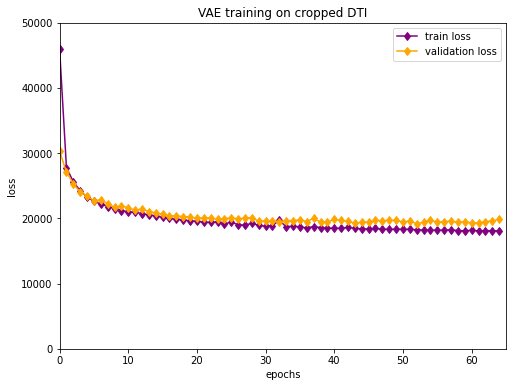

In [5]:
plot_loss(history, xmax = 65, ymax = 50000)

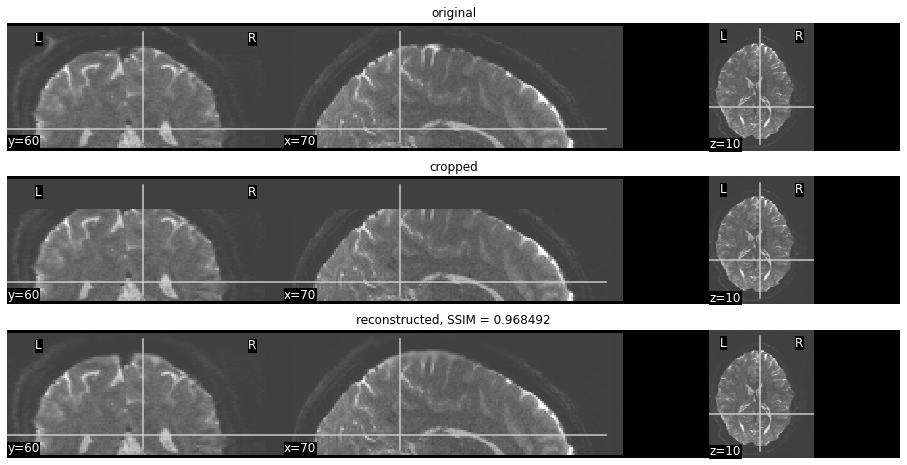

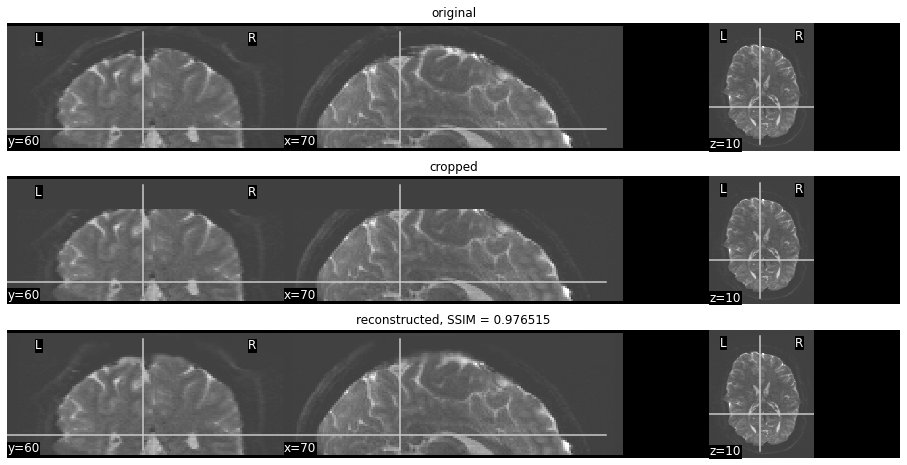

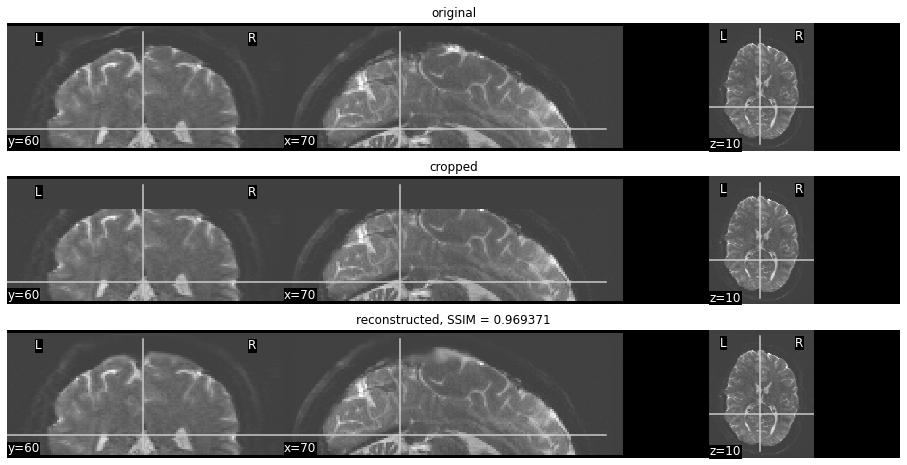

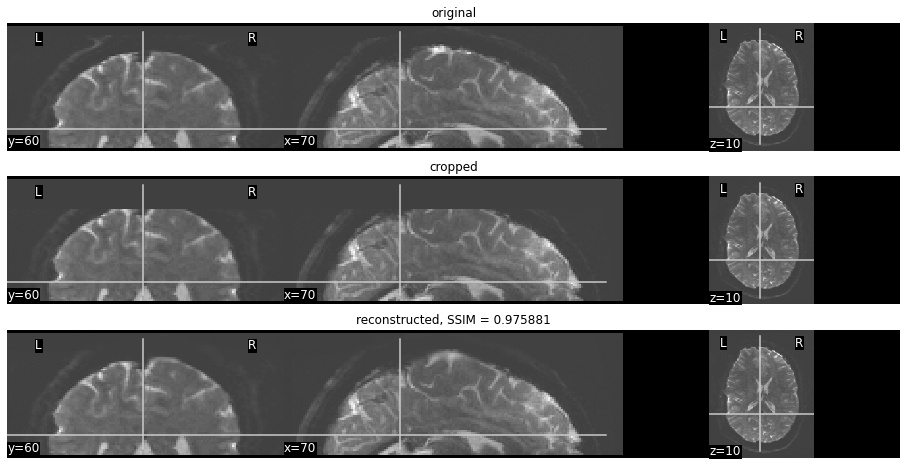

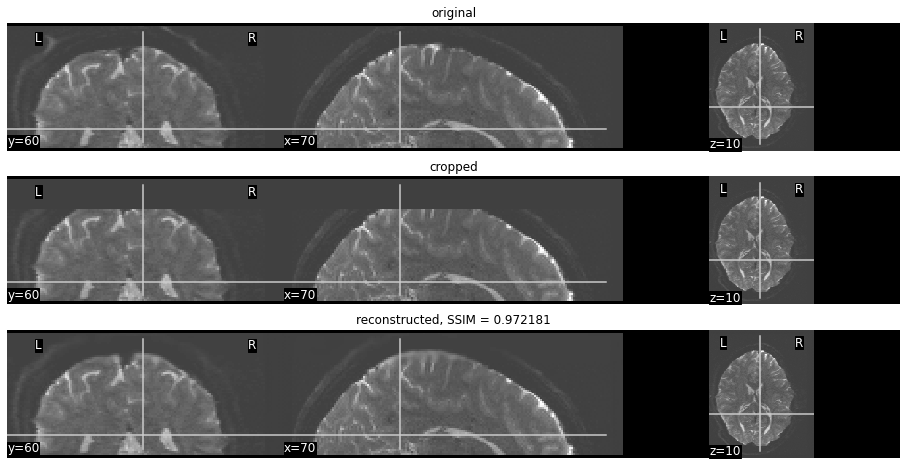

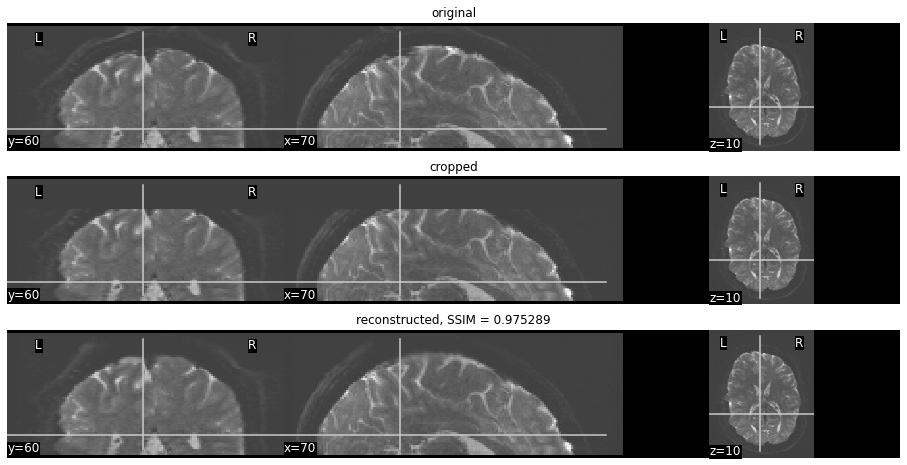

Average SSIM: 0.963040
STD SSIM: 0.026501


In [6]:
test_model(model, validation_generator)